209299478

208886333

313689804

preparations and data load

In [ ]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 60.4 MB/s eta 0:00:00


In [ ]:
!pip install sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
import seaborn as sns
import warnings
warnings.catch_warnings()
warnings.simplefilter("ignore")
import torch
from torchvision import datasets
from torch import nn
from torchvision.transforms import ToTensor,Lambda
from PIL import Image
import random
from torch.utils.tensorboard import SummaryWriter
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models
import lightning as L
from sklearn.model_selection import KFold
import time
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d gpiosenka/100-bird-species

In [ ]:
!unzip /content/100-bird-species.zip

In [ ]:
data = pd.read_csv('/content/birds.csv')

In [ ]:
data.head(200)

class id                      filepaths           labels data set  \
0         0.0  train/ABBOTTS BABBLER/001.jpg  ABBOTTS BABBLER    train   
1         0.0  train/ABBOTTS BABBLER/007.jpg  ABBOTTS BABBLER    train   
2         0.0  train/ABBOTTS BABBLER/008.jpg  ABBOTTS BABBLER    train   
3         0.0  train/ABBOTTS BABBLER/009.jpg  ABBOTTS BABBLER    train   
4         0.0  train/ABBOTTS BABBLER/002.jpg  ABBOTTS BABBLER    train   
..        ...                            ...              ...      ...   
195       1.0    train/ABBOTTS BOOBY/033.jpg    ABBOTTS BOOBY    train   
196       1.0    train/ABBOTTS BOOBY/034.jpg    ABBOTTS BOOBY    train   
197       1.0    train/ABBOTTS BOOBY/035.jpg    ABBOTTS BOOBY    train   
198       1.0    train/ABBOTTS BOOBY/036.jpg    ABBOTTS BOOBY    train   
199       1.0    train/ABBOTTS BOOBY/037.jpg    ABBOTTS BOOBY    train   

          scientific name  
0    MALACOCINCLA ABBOTTI  
1    MALACOCINCLA ABBOTTI  
2    MALACOCINCLA ABBOTTI  
3    MALACOCINCLA ABBOTTI  
4    MALACOCINCLA ABBOTTI  
..                    ...  
195      PAPASULA ABBOTTI  
196      PAPASULA ABBOTTI  
197      PAPASULA ABBOTTI  
198      PAPASULA ABBOTTI  
199      PAPASULA ABBOTTI  

[200 rows x 5 columns]

# Part 1 - Present an exploratory data analysis of the dataset that you selected

1.a

In [ ]:
# Display dimensionality of the data
print("a. Dimensionality of the data:")
print("Number of samples:", len(data))
sample_image = Image.open(data['filepaths'].iloc[0])
print("Image size:", sample_image.size)

a. Dimensionality of the data:
Number of samples: 89885
Image size: (224, 224)


1.b

In [ ]:
# Choose a random image from the dataset
random_index = random.randint(0, len(data) - 1)
image_path = data['filepaths'].iloc[random_index]
sample_image = Image.open(image_path)

# Display information about the sample image
print("Sample Image Information:")
print("Image size:", sample_image.size)
print("Number of channels:", len(sample_image.getbands()))
print("Number of classes:", len(data['labels'].unique()))

Sample Image Information:
Image size: (224, 224)
Number of channels: 3
Number of classes: 525


The data is well preprocessed, there are no null values, all images contain a bird, and the bird takes up at least 50% of the pixels in the image. Therefore there is no need to preprocess the data and it is ready to use.

In addition, we can use augmentation on the images. For example:

1. Rotation: Randomly rotating images by a certain degree.
2. Zoom: Randomly zooming into or out of images.
3. Shift: Randomly shifting images horizontally or vertically.
4. Brightness and Contrast: Randomly adjusting the brightness and contrast of images.

1.c

In [ ]:
class_counts = data['class id'].value_counts()
summary_stats = class_counts.describe()
print(summary_stats)

count    525.000000
mean     171.209524
std       20.621588
min      140.000000
25%      160.000000
50%      168.000000
75%      180.000000
max      273.000000
Name: class id, dtype: float64


There are 525 classes of birds, with each class containing at least 140 images of that bird. The number of images varies between classes, but there are sufficient images for each class to effectively train the model and achieve good classifications.

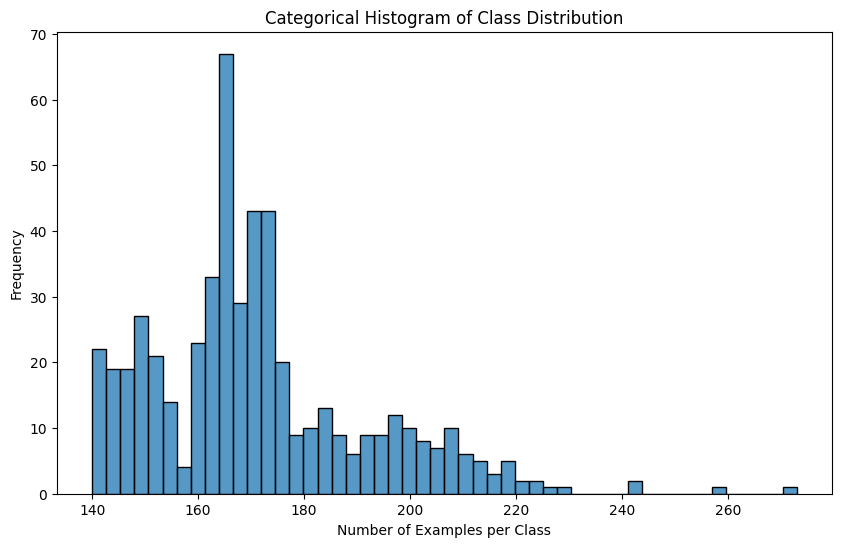

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(class_counts, bins=50, kde=False)
plt.title('Categorical Histogram of Class Distribution')
plt.xlabel('Number of Examples per Class')
plt.ylabel('Frequency')
plt.show()

1.e

An example of 25 classes:

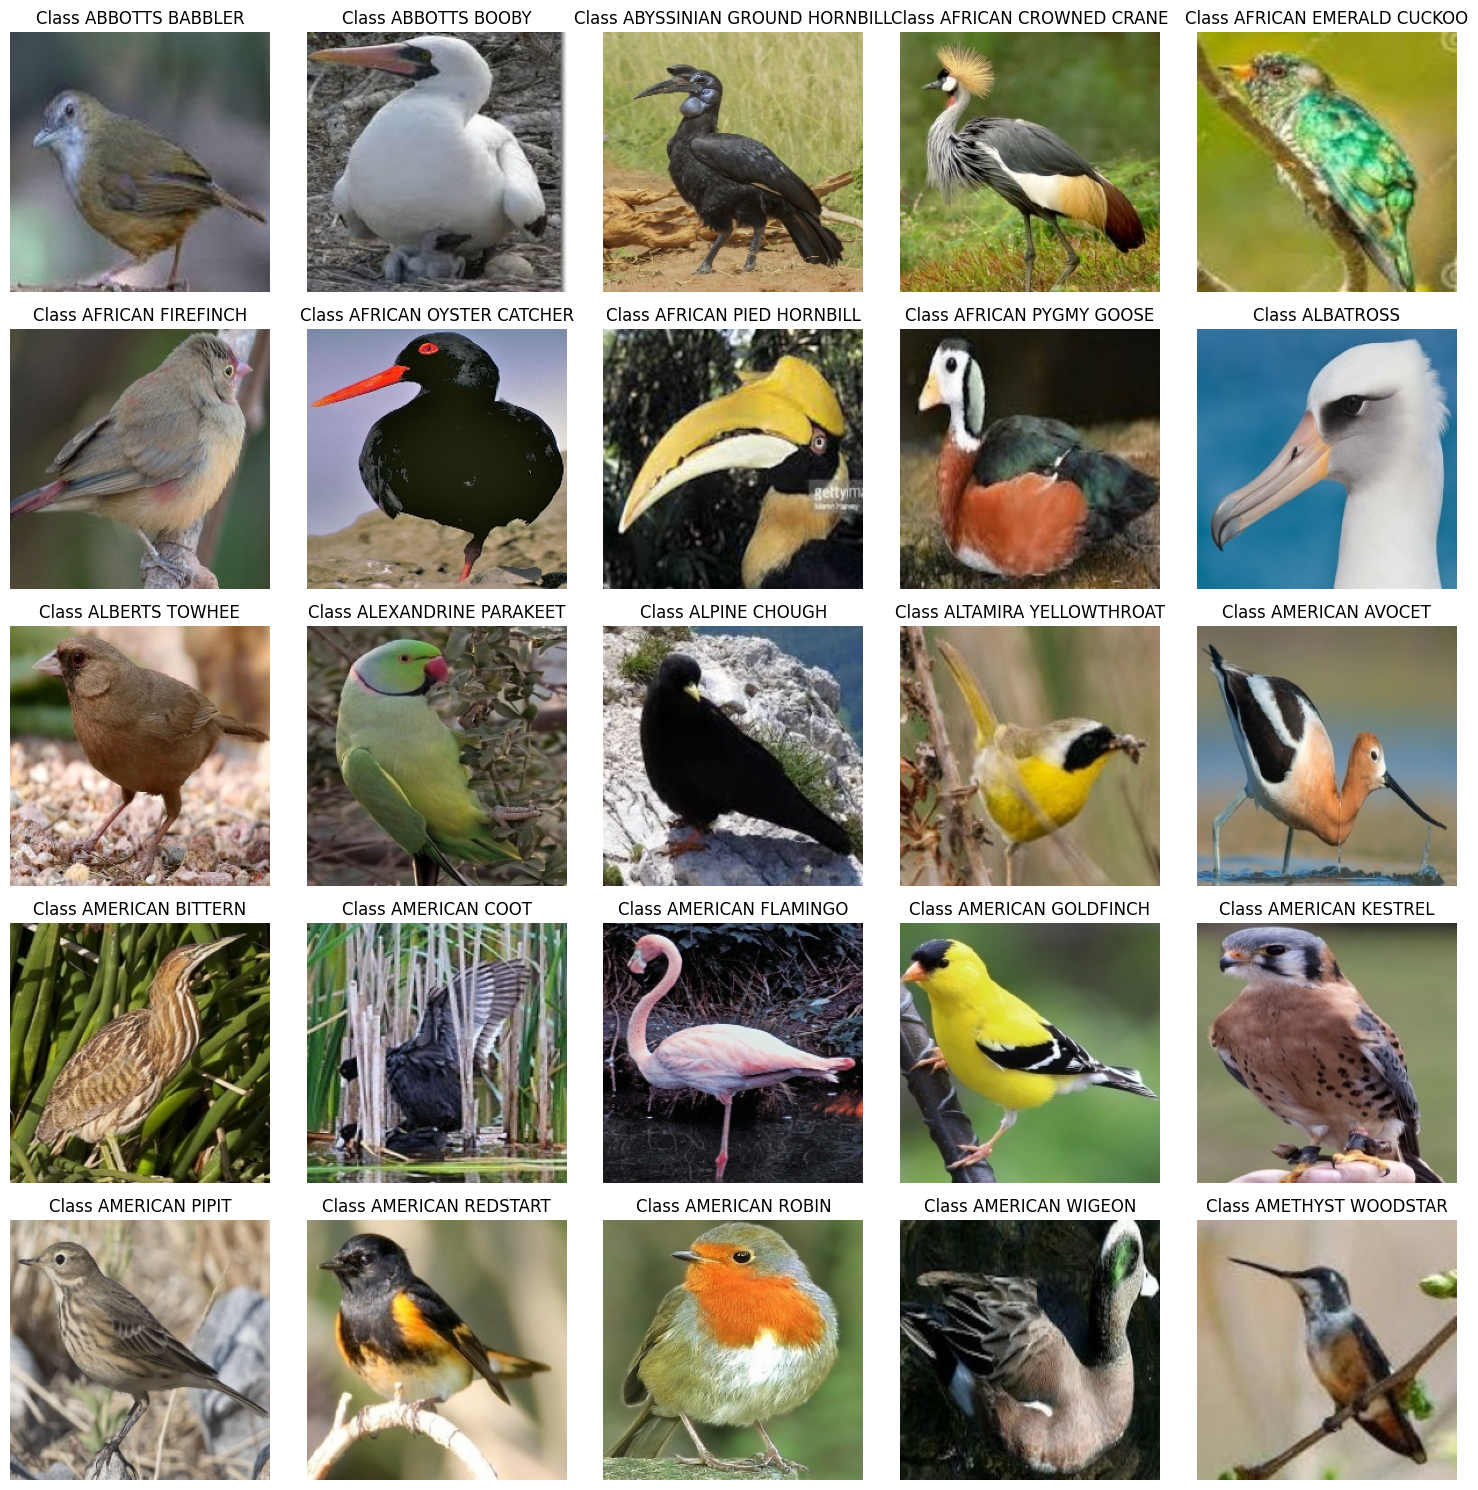

In [ ]:
# Select one image from each of the first six classes
selected_images = []

for class_id in data['labels'].unique()[:25]:
    class_indices = data[data['labels'] == class_id].index
    selected_index = random.choice(class_indices)
    image_path = data['filepaths'].iloc[selected_index]
    selected_images.append(Image.open(image_path))

# Display the selected images
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

for i in range(5):
    for j in range(5):
        axes[i, j].imshow(selected_images[i * 5 + j])
        axes[i, j].axis('off')
        axes[i, j].set_title(f"Class {data['labels'].unique()[i * 5 + j]}")

plt.tight_layout()
plt.show()

Examples of easily separable ones vs. harder more similar categories

In [ ]:
seperable = ['AMERICAN FLAMINGO', 'ALEXANDRINE PARAKEET', 'ALBATROSS']
similar = ['ABBOTTS BABBLER', 'AMERICAN PIPIT', 'ALBERTS TOWHEE']

In [ ]:
def show_images(df, classes_ls, similar=False):

  if not similar:
    print("Examples of easily separable birds\n")
  else:
    print("Examples of harder more similar birds\n")

  selected_images = []

  for class_label in classes_ls:
      class_indices = df[df['labels'] == class_label].index
      selected_index = random.choice(class_indices)
      image_path = df['filepaths'].iloc[selected_index]
      selected_images.append(Image.open(image_path))

  fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  for j in range(3):
      axes[j].imshow(selected_images[j])
      axes[j].axis('off')
      axes[j].set_title(f"Class {classes_ls[j]}")

  plt.tight_layout()
  plt.show()
  print("\n")

Examples of easily separable birds



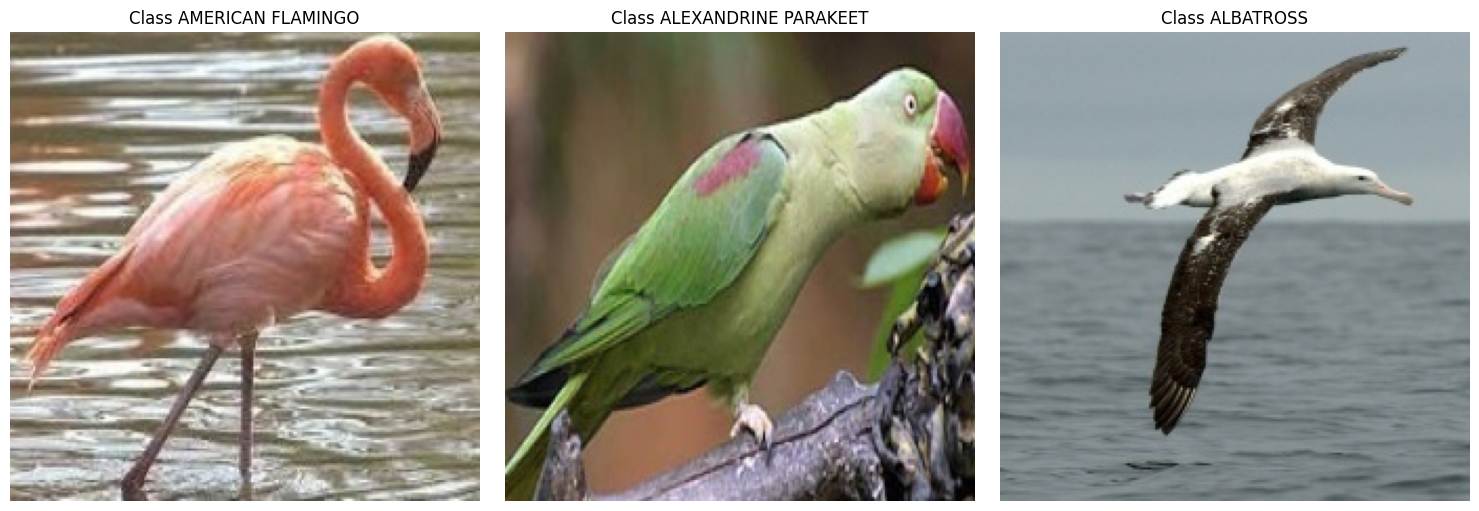



Examples of harder more similar birds



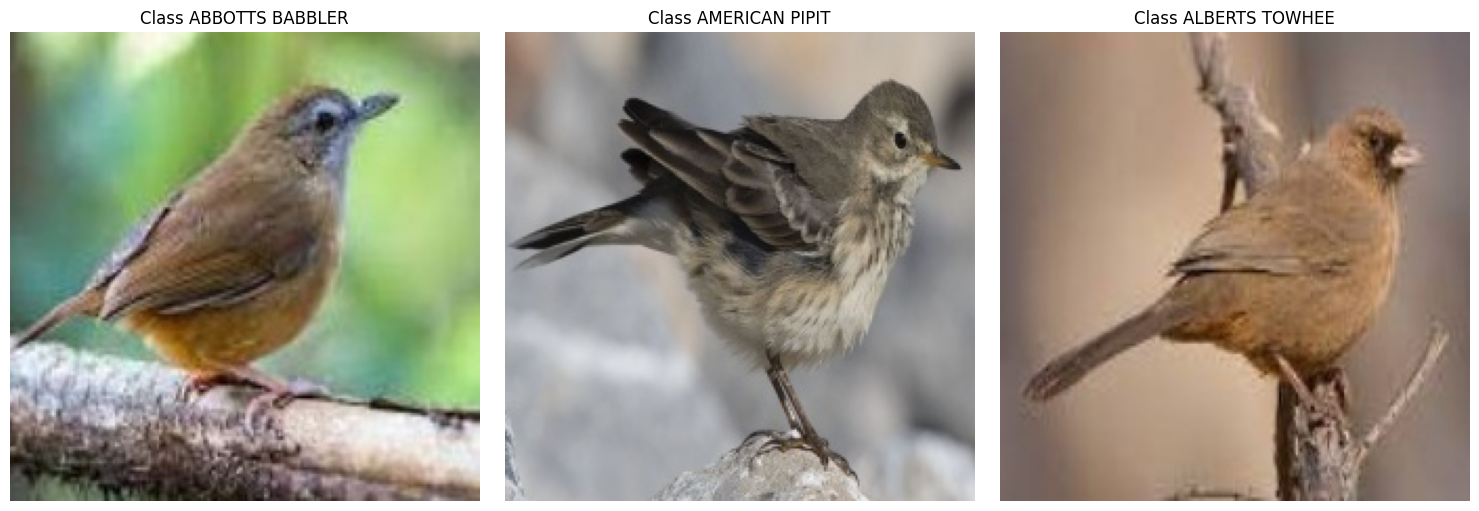

In [ ]:
show_images(data, seperable, similar=False)
show_images(data, similar, similar=True)

# Part 2 - Form a neural network graph based on the components we used in the walkthroughs in class

connect to GPU

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

preprocessing

In [ ]:
# Change 'PARAKETT  AKULET' to the correct label 'PARAKETT  AUKLET'
data['labels'] = data['labels'].str.replace('PARAKETT  AKULET', 'PARAKETT  AUKLET') ##/content/valid/PARAKETT AUKLET
data['filepaths'] = data['filepaths'].str.replace('PARAKETT  AKULET', 'PARAKETT  AUKLET')

In [ ]:
data

class id                            filepaths                   labels  \
0           0.0        train/ABBOTTS BABBLER/001.jpg          ABBOTTS BABBLER   
1           0.0        train/ABBOTTS BABBLER/007.jpg          ABBOTTS BABBLER   
2           0.0        train/ABBOTTS BABBLER/008.jpg          ABBOTTS BABBLER   
3           0.0        train/ABBOTTS BABBLER/009.jpg          ABBOTTS BABBLER   
4           0.0        train/ABBOTTS BABBLER/002.jpg          ABBOTTS BABBLER   
...         ...                                  ...                      ...   
89880     524.0  valid/BLACK BREASTED PUFFBIRD/3.jpg  BLACK BREASTED PUFFBIRD   
89881     524.0  valid/BLACK BREASTED PUFFBIRD/4.jpg  BLACK BREASTED PUFFBIRD   
89882     524.0  valid/BLACK BREASTED PUFFBIRD/1.jpg  BLACK BREASTED PUFFBIRD   
89883     524.0  valid/BLACK BREASTED PUFFBIRD/2.jpg  BLACK BREASTED PUFFBIRD   
89884     524.0  valid/BLACK BREASTED PUFFBIRD/5.jpg  BLACK BREASTED PUFFBIRD   

      data set        scientific name  
0        train   MALACOCINCLA ABBOTTI  
1        train   MALACOCINCLA ABBOTTI  
2        train   MALACOCINCLA ABBOTTI  
3        train   MALACOCINCLA ABBOTTI  
4        train   MALACOCINCLA ABBOTTI  
...        ...                    ...  
89880    valid  NOTHARCHUS PECTORALIS  
89881    valid  NOTHARCHUS PECTORALIS  
89882    valid  NOTHARCHUS PECTORALIS  
89883    valid  NOTHARCHUS PECTORALIS  
89884    valid  NOTHARCHUS PECTORALIS  

[89885 rows x 5 columns]

In [ ]:
train_df = data[data['data set'] == 'train']

In [ ]:
train_df

class id                              filepaths  \
0           0.0          train/ABBOTTS BABBLER/001.jpg   
1           0.0          train/ABBOTTS BABBLER/007.jpg   
2           0.0          train/ABBOTTS BABBLER/008.jpg   
3           0.0          train/ABBOTTS BABBLER/009.jpg   
4           0.0          train/ABBOTTS BABBLER/002.jpg   
...         ...                                    ...   
84630     524.0  train/BLACK BREASTED PUFFBIRD/151.jpg   
84631     524.0  train/BLACK BREASTED PUFFBIRD/152.jpg   
84632     524.0  train/BLACK BREASTED PUFFBIRD/153.jpg   
84633     524.0  train/BLACK BREASTED PUFFBIRD/146.jpg   
84634     524.0   train/BLACK BREASTED PUFFBIRD/99.jpg   

                        labels data set        scientific name  
0              ABBOTTS BABBLER    train   MALACOCINCLA ABBOTTI  
1              ABBOTTS BABBLER    train   MALACOCINCLA ABBOTTI  
2              ABBOTTS BABBLER    train   MALACOCINCLA ABBOTTI  
3              ABBOTTS BABBLER    train   MALACOCINCLA ABBOTTI  
4              ABBOTTS BABBLER    train   MALACOCINCLA ABBOTTI  
...                        ...      ...                    ...  
84630  BLACK BREASTED PUFFBIRD    train  NOTHARCHUS PECTORALIS  
84631  BLACK BREASTED PUFFBIRD    train  NOTHARCHUS PECTORALIS  
84632  BLACK BREASTED PUFFBIRD    train  NOTHARCHUS PECTORALIS  
84633  BLACK BREASTED PUFFBIRD    train  NOTHARCHUS PECTORALIS  
84634  BLACK BREASTED PUFFBIRD    train  NOTHARCHUS PECTORALIS  

[84635 rows x 5 columns]

In [ ]:
test_df = data[data['data set'] == 'test']

DataSet and DataLoader classes

In [ ]:
from torch.utils.data import Dataset,DataLoader
from torchvision.io import read_image
import pandas as pd
import os

class Birds_dataset(Dataset):
    def __init__(self,labels,path_list,transform=None):
        ## assumptions:
        ## birds csv contains: class_id, file path, labels, dataset, scientific name
        self.labels = labels
        self.path_list = path_list
        self.transform = transform

    def __len__(self):
        return len(self.labels)  # how many examples in the DS

    def __getitem__(self,idx):  # how to get one item
        relative_path = self.path_list[idx]
        image_path = os.path.join('/content', relative_path)
        image = read_image(image_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label  # return the label for the same index

In [ ]:
from torchvision import transforms
filepaths_train = train_df['filepaths'].tolist()
filepaths_test = test_df['filepaths'].tolist()

labels_train = train_df['class id'].tolist()
labels_test = test_df['class id'].tolist()

In [ ]:
from torchvision import transforms

# Define the desired size
desired_size = (224, 224)

# Define the transformations for training and testing
train_transform = transforms.Compose([
    transforms.Resize(desired_size)])

test_transform = transforms.Compose([
    transforms.Resize(desired_size)])

In [ ]:
train_dataset = Birds_dataset(labels=labels_train, path_list=filepaths_train, transform=train_transform)
test_dataset = Birds_dataset(labels=labels_test, path_list=filepaths_test, transform=test_transform)

In [ ]:
train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=64,shuffle=True)

In [ ]:
class Residual(nn.Module):
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super(Residual, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1,
                               stride=strides, bias=False)

        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1,
                               bias=False)
        if input_channels != num_channels:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))

        if self.conv3:
            X = self.conv3(X)
        Y = Y + X
        return F.relu(Y)

In [ ]:
def resnet_block(input_channels, num_channels,
                 num_residuals, use_1x1conv=True, strides=2):
  """ creating the blocks of the resnet """
    blk = []
    for i in range(num_residuals):
        if i == 0:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=use_1x1conv,
                                strides=strides))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [ ]:
class Resnet18(nn.Module):
  """ defining the layers of the network """
    def __init__(self,):
        super(Resnet18, self).__init__()

        self.b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7,
                                          stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2,
                                padding=1))

        self.b2 = nn.Sequential(*resnet_block(64, 64, 2,
                                              use_1x1conv=False,
                                              strides=1))

        self.b3 = nn.Sequential(*resnet_block(64, 128, 2,
                                              strides=2))

        self.b4 = nn.Sequential(*resnet_block(128, 256, 2,
                                              strides=2))

        self.b5 = nn.Sequential(*resnet_block(256, 512, 2,
                                              strides=2))

        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.flat = nn.Flatten()
        self.linear = nn.Linear(512, 525)

    def forward(self, x):
        x = x.float()  # Convert input to float type
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.b5(x)

        x = self.pool(x)
        x = self.flat(x)
        x = self.linear(x)

        return x

In [ ]:
resnet = Resnet18().to(device)

In [ ]:
resnet

Resnet18(
  (b1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (b2): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
batch_size = 64
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        y = y.long()
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:  # not printing the loss each time
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            y = y.long()
            test_loss += loss_fn(pred, y).item()
            correct += (F.softmax(pred, -1).argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
def test(dataloader, model, loss_fn): ### same return function, just return one batch predictions for printing
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    first_batch = True
    with torch.no_grad():
        for i, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            y = y.long()
            test_loss += loss_fn(pred, y).item()
            correct += (F.softmax(pred, -1).argmax(1) == y).type(torch.float).sum().item()
            if first_batch == True:
              batch1 = (X,y)
              correct_indices = []
              incorrect_indices = []
              y_pred = F.softmax(pred, dim=-1).argmax(dim=1)
              correct_mask = (y_pred == y)
              correct_indices.extend([i * dataloader.batch_size + idx.item() for idx in torch.nonzero(correct_mask)])
              incorrect_indices.extend([i * dataloader.batch_size + idx.item() for idx in torch.nonzero(~correct_mask)])
              first_batch = False

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return batch1, correct_indices, incorrect_indices

In [ ]:
# Record the start time
start_time = time.time()
# Define the number of folds and batch size
k_folds = 5
batch_size = 64

# Initialize the k-fold cross validation
kf = KFold(n_splits=k_folds, shuffle=True)

# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold + 1}")
    print("-------")

    # Define the data loaders for the current fold
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
    )
    val_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(val_idx),
    )

    # Initialize the model and optimizer
    model = resnet.to(device)
    num_of_epochs = 5

    # Train the model on the current fold
    for epoch in range(1, num_of_epochs+1):
        train(train_loader, model, loss_fn, optimizer)

    # Evaluate the model on the test set
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          target = target.long()
          test_loss += loss_fn(output, target).item()
          correct += (F.softmax(output, -1).argmax(1) == target).type(torch.float).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)

    # Print the results for the current fold
    print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n")

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time} seconds")

Fold 1
-------
loss: 6.344542  [    0/84635]
loss: 6.431133  [  640/84635]
loss: 6.400594  [ 1280/84635]
loss: 6.395330  [ 1920/84635]
loss: 6.321713  [ 2560/84635]
loss: 6.312338  [ 3200/84635]
loss: 6.206997  [ 3840/84635]
loss: 6.206722  [ 4480/84635]
loss: 6.284328  [ 5120/84635]
loss: 6.272792  [ 5760/84635]
loss: 6.196633  [ 6400/84635]
loss: 6.187445  [ 7040/84635]
loss: 6.138219  [ 7680/84635]
loss: 6.096180  [ 8320/84635]
loss: 6.137716  [ 8960/84635]
loss: 5.940568  [ 9600/84635]
loss: 6.058736  [10240/84635]
loss: 6.065509  [10880/84635]
loss: 5.955779  [11520/84635]
loss: 6.022442  [12160/84635]
loss: 5.900071  [12800/84635]
loss: 5.872338  [13440/84635]
loss: 5.987978  [14080/84635]
loss: 5.921232  [14720/84635]
loss: 6.078130  [15360/84635]
loss: 5.663342  [16000/84635]
loss: 5.952912  [16640/84635]
loss: 5.634348  [17280/84635]
loss: 5.783416  [17920/84635]
loss: 5.705179  [18560/84635]
loss: 5.741649  [19200/84635]
loss: 5.323060  [19840/84635]
loss: 5.438603  [20480/84

In [ ]:
test(test_loader,resnet, loss_fn)

Test Error: 
 Accuracy: 85.1%, Avg loss: 0.648100 



### Examples for correct preds & uncorrect Preds:

Examples of correct predictions:


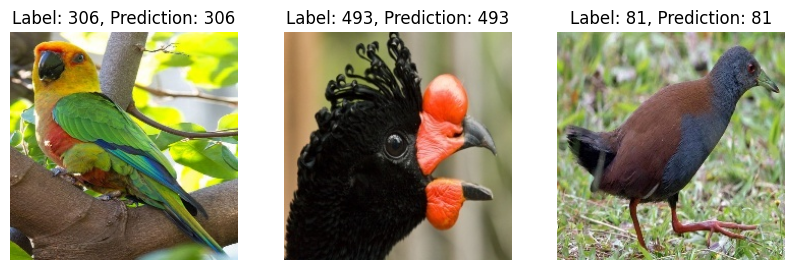

Examples of incorrect predictions:


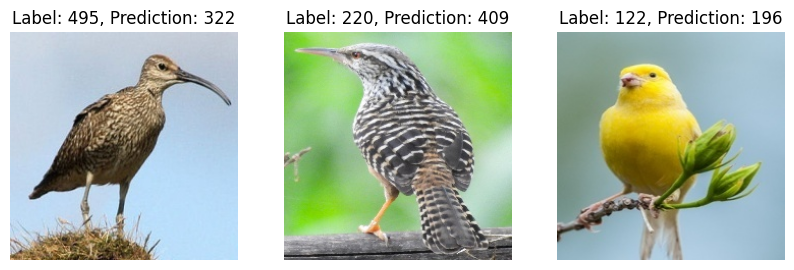

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to display images
def show_images(indices, label):
    print(f"Examples of {label} predictions:")
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    for i, idx in enumerate(indices[:3]):
        example = example_batch[0][idx].cpu().numpy()  # Convert tensor to numpy array
        label = example_batch[1][idx].item()  # Get the label
        prediction = model(example_batch[0][idx].unsqueeze(0).to(device)).argmax(dim=1).item()  # Get the prediction
        example = np.transpose(example, (1, 2, 0))  # Reshape to (H, W, C) for imshow
        axes[i].imshow(example)
        axes[i].set_title(f"Label: {label}, Prediction: {prediction}")
        axes[i].axis('off')
    plt.show()

# Show images of correct predictions
show_images(correct_idx, "correct")

# Show images of incorrect predictions
show_images(uncorrect_idx, "incorrect")


#2.a - same, but keeping results in Neptun AI

In [ ]:
! pip install -U neptune numpy torch torchvision tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.5/481.5 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
import neptune
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
from datetime import timedelta

In [ ]:
run = neptune.init_run(
    project='DL-workshop/HW1-DL-workshop',
    tags="Colab Notebook",
    name='2.a - basic model'
    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0ZGU3NGI5Yi1lMWIxLTQ4YTEtOTdjZS1iMTY2OTEwZjU1MWIifQ==',
)

https://app.neptune.ai/DL-workshop/HW1-DL-workshop/e/HWDLWOR-10


In [ ]:
run['params/model'] = '2.a - basic'
run['params/dataset'] = 'Birds_dataset'
run['params/batch_size'] = 64
run['params/number_of_classes'] = 525

until trainig loop -the same

In [ ]:
def train(dataloader, model, loss_fn, optimizer):  # same as before but now keep in Neptun
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        y = y.long()
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            # Log loss and accuracy to Neptune
            run['train/loss'].log(loss)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            y = y.long()
            test_loss += loss_fn(pred, y).item()
            correct += (F.softmax(pred, -1).argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    run['test/accuracy'].log(correct)
    run['test/loss'].log(test_loss)

In [ ]:
# Record the start time
start_time = time.time()
# Define the number of folds and batch size
k_folds = 5
batch_size = 64

# Initialize the k-fold cross validation
kf = KFold(n_splits=k_folds, shuffle=True)

# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold + 1}")
    print("-------")

    # Define the data loaders for the current fold
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
    )
    val_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(val_idx),
    )

    # Initialize the model and optimizer
    model = resnet.to(device)
    num_of_epochs = 5

    # Train the model on the current fold
    for epoch in range(1, num_of_epochs+1):
        train(train_loader, model, loss_fn, optimizer)

    # Evaluate the model on the test set
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          target = target.long()
          test_loss += loss_fn(output, target).item()
          correct += (F.softmax(output, -1).argmax(1) == target).type(torch.float).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)

    # Print the results for the current fold
    print(f"validation Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n")
    run['validation/accuracy'].log(accuracy)
    run['validation/loss'].log(test_loss)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = (end_time - start_time)/60
elapsed_time_timedelta = timedelta(minutes=elapsed_time)
elapsed_time_formatted = str(elapsed_time_timedelta)
print(f"Elapsed Time: {elapsed_time_formatted}")
run['params/time'] = elapsed_time_formatted

Fold 1
-------
loss: 6.305646  [    0/84635]
loss: 6.480788  [  640/84635]
loss: 6.265034  [ 1280/84635]
loss: 6.268537  [ 1920/84635]
loss: 6.291670  [ 2560/84635]
loss: 6.176235  [ 3200/84635]
loss: 6.222768  [ 3840/84635]
loss: 6.284534  [ 4480/84635]
loss: 6.152000  [ 5120/84635]
loss: 5.977105  [ 5760/84635]
loss: 6.004072  [ 6400/84635]
loss: 6.027260  [ 7040/84635]
loss: 5.870494  [ 7680/84635]
loss: 5.885963  [ 8320/84635]
loss: 5.959700  [ 8960/84635]
loss: 6.016816  [ 9600/84635]
loss: 5.846800  [10240/84635]
loss: 5.905678  [10880/84635]
loss: 5.651036  [11520/84635]
loss: 5.766363  [12160/84635]
loss: 5.791913  [12800/84635]
loss: 5.692348  [13440/84635]
loss: 5.921166  [14080/84635]
loss: 5.834772  [14720/84635]
loss: 5.672862  [15360/84635]
loss: 5.519820  [16000/84635]
loss: 5.691944  [16640/84635]
loss: 5.689124  [17280/84635]
loss: 5.679795  [17920/84635]
loss: 5.390551  [18560/84635]
loss: 5.470984  [19200/84635]
loss: 5.420094  [19840/84635]
loss: 5.765581  [20480/84

In [ ]:
test(test_loader,resnet, loss_fn)

Test: 
 Accuracy: 85.6%, Avg loss: 0.654691 



In [ ]:
from google.colab import drive  # to keep the trained model in drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_save_name = 'resnet18'
path = F"/content/gdrive/MyDrive/DL workshop/{model_save_name}"
torch.save(model.state_dict(), path)

In [ ]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/DL-workshop/HW1-DL-workshop/e/HWDLWOR-10/metadata


In [ ]:
a = resnet.to(device)
path = F"/content/gdrive/MyDrive/DL workshop/resnet18"
a.load_state_dict(torch.load(path))

<All keys matched successfully>

# 2.c - add improvments option A

Hyperparameter Tuning

In [ ]:
# Adjust the optimizer definition to use a scheduler
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

def train(dataloader, model, loss_fn, optimizer, scheduler):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        y = y.long()
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            run['train/loss'].log(loss)

    # Update the learning rate
    scheduler.step()

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            y = y.long()
            test_loss += loss_fn(pred, y).item()
            correct += (F.softmax(pred, -1).argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    run['test/accuracy'].log(correct)
    run['test/loss'].log(test_loss)

In [ ]:
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)
train_idx, val_idx = next(iter(kf.split(train_dataset)))
num_of_epochs = 5

In [ ]:
# Initialize the k-fold cross-validation with hyperparameter tuning
learning_rates = [1e-3, 5e-4, 1e-4]  # Example learning rates to try
batch_sizes = [32, 64, 128]  # Example batch sizes to try

results = {}  # Dictionary to store results

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Learning Rate: {lr}, Batch Size: {batch_size}")

        # Initialize the model, optimizer, and scheduler
        model = Resnet18().to(device)  # Instantiate ResNet model
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

        # Initialize the data loaders for the current fold
        train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=batch_size,
            sampler=torch.utils.data.SubsetRandomSampler(train_idx),
        )
        val_loader = DataLoader(
            dataset=train_dataset,
            batch_size=batch_size,
            sampler=torch.utils.data.SubsetRandomSampler(val_idx),
        )

        # Train the model on the current fold
        for epoch in range(1, num_of_epochs+1):
            train(train_loader, model, loss_fn, optimizer, scheduler)

        # Evaluate the model on the test set
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                target = target.long()
                test_loss += loss_fn(output, target).item()
                correct += (F.softmax(output, -1).argmax(1) == target).type(torch.float).sum().item()

        test_loss /= len(test_loader.dataset)
        accuracy = 100.0 * correct / len(test_loader.dataset)

        # Store the results in the dictionary
        results[(lr, batch_size)] = (test_loss, accuracy)

        # Print the results for the current variation
        print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%\n")

Learning Rate: 0.001, Batch Size: 32
loss: 6.406523  [    0/52500]
loss: 6.824287  [  320/52500]
loss: 6.720167  [  640/52500]
loss: 6.636881  [  960/52500]
loss: 6.460703  [ 1280/52500]
loss: 6.407368  [ 1600/52500]
loss: 6.303906  [ 1920/52500]
loss: 6.304863  [ 2240/52500]
loss: 6.355924  [ 2560/52500]
loss: 6.293724  [ 2880/52500]
loss: 6.288867  [ 3200/52500]
loss: 6.409280  [ 3520/52500]
loss: 6.270465  [ 3840/52500]
loss: 6.363653  [ 4160/52500]
loss: 6.397111  [ 4480/52500]
loss: 6.227684  [ 4800/52500]
loss: 6.238918  [ 5120/52500]
loss: 6.255193  [ 5440/52500]
loss: 6.272738  [ 5760/52500]
loss: 6.258626  [ 6080/52500]
loss: 6.275861  [ 6400/52500]
loss: 6.253782  [ 6720/52500]
loss: 6.342653  [ 7040/52500]
loss: 6.330618  [ 7360/52500]
loss: 6.296588  [ 7680/52500]
loss: 6.350368  [ 8000/52500]
loss: 6.269081  [ 8320/52500]
loss: 6.194985  [ 8640/52500]
loss: 6.274936  [ 8960/52500]
loss: 6.218346  [ 9280/52500]
loss: 6.246158  [ 9600/52500]
loss: 6.300926  [ 9920/52500]
los

In [ ]:
# Print all the results
print("\nResults:")
for (lr, batch_size), (test_loss, accuracy) in results.items():
    print(f"Learning Rate: {lr}, Batch Size: {batch_size}, Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")


Results:
Learning Rate: 0.001, Batch Size: 32, Average loss: 0.0382, Accuracy: 49.37%
Learning Rate: 0.001, Batch Size: 64, Average loss: 0.0267, Accuracy: 59.89%
Learning Rate: 0.001, Batch Size: 128, Average loss: 0.0188, Accuracy: 70.78%
Learning Rate: 0.0005, Batch Size: 32, Average loss: 0.0172, Accuracy: 72.72%
Learning Rate: 0.0005, Batch Size: 64, Average loss: 0.0197, Accuracy: 68.42%
Learning Rate: 0.0005, Batch Size: 128, Average loss: 0.0251, Accuracy: 62.21%
Learning Rate: 0.0001, Batch Size: 32, Average loss: 0.0214, Accuracy: 68.19%
Learning Rate: 0.0001, Batch Size: 64, Average loss: 0.0259, Accuracy: 60.15%
Learning Rate: 0.0001, Batch Size: 128, Average loss: 0.0356, Accuracy: 47.66%


# 2.c - add improvments option B

Add more layers to the existing ResNet18 architecture by increasing the number of residual blocks in each stage of the network.

In [ ]:
class Resnet18(nn.Module):
    def __init__(self):
        super(Resnet18, self).__init__()

        self.b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7,
                                          stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2,
                                padding=1))

        self.b2 = nn.Sequential(*resnet_block(64, 64, 3,  # Increase the number of residual blocks
                                              use_1x1conv=False,
                                              strides=1))

        self.b3 = nn.Sequential(*resnet_block(64, 128, 4,  # Increase the number of residual blocks
                                              strides=2))

        self.b4 = nn.Sequential(*resnet_block(128, 256, 6,  # Increase the number of residual blocks
                                              strides=2))

        self.b5 = nn.Sequential(*resnet_block(256, 512, 3,  # Increase the number of residual blocks
                                              strides=2))

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flat = nn.Flatten()
        self.linear = nn.Linear(512, 525)

    def forward(self, x):
        x = x.float()  # Convert input to float type
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.b5(x)

        x = self.pool(x)
        x = self.flat(x)
        x = self.linear(x)

        return x

In [ ]:
# Record the start time
start_time = time.time()
# Define the number of folds and batch size
k_folds = 5
batch_size = 32

# Initialize the k-fold cross validation
kf = KFold(n_splits=k_folds, shuffle=True)

# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold + 1}")
    print("-------")

    # Define the data loaders for the current fold
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
    )
    val_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(val_idx),
    )

    # Initialize the model and optimizer
    model = resnet.to(device)
    num_of_epochs = 5

    # Train the model on the current fold
    for epoch in range(1, num_of_epochs+1):
        train(train_loader, model, loss_fn, optimizer)

    # Evaluate the model on the test set
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          target = target.long()
          test_loss += loss_fn(output, target).item()
          correct += (F.softmax(output, -1).argmax(1) == target).type(torch.float).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)

    # Print the results for the current fold
    print(f"Fold num {fold}:validation Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n")
    run['validation/accuracy'].log(accuracy)
    run['validation/loss'].log(test_loss)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = (end_time - start_time)/60
elapsed_time_timedelta = timedelta(minutes=elapsed_time)
elapsed_time_formatted = str(elapsed_time_timedelta)
print(f"Elapsed Time: {elapsed_time_formatted}")
run['params/time'] = elapsed_time_formatted

Fold 1
-------
loss: 6.370843  [    0/84635]
loss: 6.599343  [  640/84635]
loss: 6.585792  [ 1280/84635]
loss: 6.376587  [ 1920/84635]
loss: 6.203238  [ 2560/84635]
loss: 6.384194  [ 3200/84635]
loss: 6.426508  [ 3840/84635]
loss: 6.357008  [ 4480/84635]
loss: 6.097598  [ 5120/84635]
loss: 6.163757  [ 5760/84635]
loss: 6.146540  [ 6400/84635]
loss: 6.070644  [ 7040/84635]
loss: 6.092062  [ 7680/84635]
loss: 6.153675  [ 8320/84635]
loss: 6.152994  [ 8960/84635]
loss: 5.897058  [ 9600/84635]
loss: 6.241061  [10240/84635]
loss: 6.241848  [10880/84635]
loss: 6.220589  [11520/84635]
loss: 5.996272  [12160/84635]
loss: 5.878389  [12800/84635]
loss: 5.763164  [13440/84635]
loss: 5.927672  [14080/84635]
loss: 5.964835  [14720/84635]
loss: 5.884521  [15360/84635]
loss: 5.768670  [16000/84635]
loss: 6.089166  [16640/84635]
loss: 5.887514  [17280/84635]
loss: 5.979872  [17920/84635]
loss: 5.638522  [18560/84635]
loss: 5.727383  [19200/84635]
loss: 5.744393  [19840/84635]
loss: 5.829436  [20480/84

In [ ]:
test(test_loader,resnet, loss_fn)

Test: 
 Accuracy: 89.4%, Avg loss: 0.485034 



#2.d - inference-time-augmentation

In [ ]:
import torch
from torchvision import transforms

def augment_image(img_tensor, num_augmentations=5, device='cuda'):
    # Move input tensor to the same device as the model
    img_tensor = img_tensor.to(device)

    # Convert the PyTorch tensor to a PIL Image
    img_pil = transforms.ToPILImage()(img_tensor)

    # Create a torchvision transforms.Compose for data augmentation
    transform = transforms.Compose([
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ToTensor()
    ])

    augmented_tensors = [transform(img_pil) for _ in range(num_augmentations)]
    augmented_tensors.append(img_tensor)


    return augmented_tensors




In [ ]:
import torch.nn.functional as F
from collections import Counter
import neptune

def test_augmented(dataloader, model, loss_fn, num_augmentations=5):

    run = neptune.init_run(
        project='DL-workshop/HW1-DL-workshop',
        tags="Colab Notebook",
        name='2.d - inference-time-augmentation ',
        api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4OTBiZDdkNy03YzlmLTQ4N2ItOWQ2YS0wMDRhYTE2ODRhMTMifQ==',
    )

    run['params/model'] = '2.d - inference-time-augmentation'
    run['params/dataset'] = 'Birds_dataset'
    run['params/batch_size'] = 64
    run['params/number_of_classes'] = 525

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    total_predictions = 0
    with torch.no_grad():
      for batch_idx, (X, y) in enumerate(dataloader):
          X, y = X.to(device), y.to(device)
          batch_size = X.size(0)
          # print(batch_size)
          all_predictions = []
          for img in X:
              augmented_X = [aug.to(device) for aug in augment_image(img, num_augmentations=num_augmentations)] #
              stacked_tensor = torch.stack(augmented_X, dim=0)
              average_tensor = torch.mean(stacked_tensor, dim=0)
              cur_predictions = []
              for aug_X in augmented_X:
                  aug_X = aug_X.unsqueeze(0)
                  pred = model(aug_X)
                  cur_predictions.append(pred)
              stacked_tensor = torch.stack(cur_predictions, dim=0)
              average_tensor = torch.mean(stacked_tensor, dim=0)
              all_predictions.append(average_tensor)
          all_predictions = torch.cat(all_predictions, dim=0)
          y = y.long()
          test_loss += loss_fn(all_predictions, y).item()
          correct += (F.softmax(all_predictions, -1).argmax(1) == y).sum().item()
          total_predictions += batch_size
          run['test/accuracy'].log(correct / total_predictions)
          run['test/loss'].log(test_loss / (batch_idx + 1))
    test_loss /= num_batches
    correct /= total_predictions
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    run.stop()


In [ ]:
test_augmented(test_loader, resnet, loss_fn)

https://app.neptune.ai/DL-workshop/HW1-DL-workshop/e/HWDLWOR-26
Test Error: 
 Accuracy: 4.3%, Avg loss: 7.240501 



#2.e - add new catagory

In [ ]:
run = neptune.init_run(
    project='DL-workshop/HW1-DL-workshop',
    tags="Colab Notebook",
    name='2.e -new label',
    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0ZGU3NGI5Yi1lMWIxLTQ4YTEtOTdjZS1iMTY2OTEwZjU1MWIifQ==',
)

https://app.neptune.ai/DL-workshop/HW1-DL-workshop/e/HWDLWOR-11


In [ ]:
run['params/model'] = '2.e -new label'
run['params/dataset'] = 'Birds_dataset'
run['params/batch_size'] = 32
run['params/number_of_classes'] = 526

In [ ]:
# create new label folders
!mkdir -p train/'WRINKLED HORNBILL'
!mkdir -p test/'WRINKLED HORNBILL'

In [ ]:
# add the photos from to the right folders
!mv 001.jpg train/'WRINKLED HORNBILL'
!mv 002.jpg train/'WRINKLED HORNBILL'
!mv 003.jpg train/'WRINKLED HORNBILL'
!mv 004.jpg train/'WRINKLED HORNBILL'
!mv 005.jpg train/'WRINKLED HORNBILL'
!mv 006.jpg train/'WRINKLED HORNBILL'
!mv 007.jpg train/'WRINKLED HORNBILL'
!mv 008.jpg train/'WRINKLED HORNBILL'
!mv 009.jpg train/'WRINKLED HORNBILL'
!mv 010.jpg train/'WRINKLED HORNBILL'

In [ ]:
# add the photos from to the right folders
!mv 11.jpg test/'WRINKLED HORNBILL'
!mv 12.jpg test/'WRINKLED HORNBILL'
!mv 13.jpg test/'WRINKLED HORNBILL'
!mv 14.JPG test/'WRINKLED HORNBILL'
!mv 15.jpg test/'WRINKLED HORNBILL'

In [ ]:
from PIL import Image

def resize_image(image_path, output_path, target_size=(224, 224)):  # resize the images to be in the right size
    # Open the image file
    image = Image.open(image_path)

    # Resize the image to the target size
    resized_image = image.resize(target_size)

    # Save the resized image to the output path
    resized_image.save(output_path)

In [ ]:
new_train_photos = ['/content/train/WRINKLED HORNBILL/001.jpg',
                    '/content/train/WRINKLED HORNBILL/002.jpg',
                    '/content/train/WRINKLED HORNBILL/003.jpg',
                    '/content/train/WRINKLED HORNBILL/004.jpg',
                    '/content/train/WRINKLED HORNBILL/005.jpg',
                    '/content/train/WRINKLED HORNBILL/006.jpg',
                    '/content/train/WRINKLED HORNBILL/007.jpg',
                    '/content/train/WRINKLED HORNBILL/008.jpg',
                    '/content/train/WRINKLED HORNBILL/009.jpg',
                    '/content/train/WRINKLED HORNBILL/010.jpg']

for photo_path in new_train_photos:
  resize_image(photo_path,photo_path,)


new_test_photos = ['/content/test/WRINKLED HORNBILL/11.jpg',
                   '/content/test/WRINKLED HORNBILL/12.jpg',
                   '/content/test/WRINKLED HORNBILL/13.jpg',
                   '/content/test/WRINKLED HORNBILL/14.JPG',
                   '/content/test/WRINKLED HORNBILL/15.jpg']

for photo_path in new_test_photos:
  resize_image(photo_path,photo_path,)

 # add the photos to the df
new_rows_train = pd.DataFrame({
    'class id': [525] * len(new_train_photos),
    'filepaths': new_train_photos,
    'labels': ['WRINKLED HORNBILL'] * len(new_train_photos),
    'data set': ['train'] * len(new_train_photos),
    'scientific name': ['Rhabdotorrhinus corrugatus'] * len(new_train_photos),
})

new_rows_test = pd.DataFrame({
    'class id': [525] * len(new_test_photos),
    'filepaths': new_test_photos,
    'labels': ['WRINKLED HORNBILL'] * len(new_test_photos),
    'data set': ['test'] * len(new_test_photos),
    'scientific name': ['Rhabdotorrhinus corrugatus'] * len(new_test_photos),
})

# Concatenate the new rows to the original DataFrame
train_df = pd.concat([train_df, new_rows_train], ignore_index=True)
test_df = pd.concat([test_df, new_rows_test], ignore_index=True)

In [ ]:
# Group the DataFrame by 'class id' and sample 10 examples from each group
random_samples = train_df.groupby('class id', group_keys=False).apply(lambda x: x.sample(len(x))) # each label will be with max photos

# Reset the index of the resulting DataFrame
train_df = random_samples.reset_index(drop=True)

In [ ]:
filepaths_train = train_df['filepaths'].tolist()
filepaths_test = test_df['filepaths'].tolist()

labels_train = train_df['class id'].tolist()
labels_test = test_df['class id'].tolist()

In [ ]:
train_dataset = Birds_dataset(labels=labels_train, path_list=filepaths_train, transform=train_transform)
test_dataset = Birds_dataset(labels=labels_test, path_list=filepaths_test, transform=test_transform)

In [ ]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True)

In [ ]:
class Residual(nn.Module):
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super(Residual, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1,
                               stride=strides, bias=False)

        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1,
                               bias=False)
        if input_channels != num_channels:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))

        if self.conv3:
            X = self.conv3(X)
        Y = Y + X
        return F.relu(Y)

In [ ]:
def resnet_block(input_channels, num_channels,
                 num_residuals, use_1x1conv=True, strides=2):
    blk = []
    for i in range(num_residuals):
        if i == 0:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=use_1x1conv,
                                strides=strides))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [ ]:
class Resnet18(nn.Module):
    def __init__(self,):
        super(Resnet18, self).__init__()

        self.b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7,
                                          stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2,
                                padding=1))

        self.b2 = nn.Sequential(*resnet_block(64, 64, 2,
                                              use_1x1conv=False,
                                              strides=1))

        self.b3 = nn.Sequential(*resnet_block(64, 128, 2,
                                              strides=2))

        self.b4 = nn.Sequential(*resnet_block(128, 256, 2,
                                              strides=2))

        self.b5 = nn.Sequential(*resnet_block(256, 512, 2,
                                              strides=2))

        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.flat = nn.Flatten()
        self.linear = nn.Linear(512, 526)

    def forward(self, x):
        x = x.float()  # Convert input to float type
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.b5(x)

        x = self.pool(x)
        x = self.flat(x)
        x = self.linear(x)

        return x

In [ ]:
resnet = Resnet18().to(device)

In [ ]:
resnet  # to see that now we have 526 classes

Resnet18(
  (b1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (b2): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        y = y.long()
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            # Log loss and accuracy to Neptune
            run['train/loss'].log(loss)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            y = y.long()
            test_loss += loss_fn(pred, y).item()
            correct += (F.softmax(pred, -1).argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    run['test/accuracy'].log(correct)
    run['test/loss'].log(test_loss)

In [ ]:
# Record the start time
start_time = time.time()
# Define the number of folds and batch size
k_folds = 5
batch_size = 32

# Initialize the k-fold cross validation
kf = KFold(n_splits=k_folds, shuffle=True)

# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold + 1}")
    print("-------")

    # Define the data loaders for the current fold
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
    )
    val_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(val_idx),
    )

    # Initialize the model and optimizer
    model = resnet.to(device)
    num_of_epochs = 5

    # Train the model on the current fold
    for epoch in range(1, num_of_epochs+1):
        train(train_loader, model, loss_fn, optimizer)

    # Evaluate the model on the test set
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          target = target.long()
          test_loss += loss_fn(output, target).item()
          correct += (F.softmax(output, -1).argmax(1) == target).type(torch.float).sum().item()

    test_loss /= len(val_loader.dataset)
    accuracy = 100.0 * correct / len(val_loader.dataset)

    # Print the results for the current fold
    print(f"validation Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(val_loader.dataset)} ({accuracy:.2f}%)\n")
    run['validation/accuracy'].log(accuracy)
    run['validation/loss'].log(test_loss)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = (end_time - start_time)/60
elapsed_time_timedelta = timedelta(minutes=elapsed_time)
elapsed_time_formatted = str(elapsed_time_timedelta)
print(f"Elapsed Time: {elapsed_time_formatted}")
run['train/time'] = elapsed_time_formatted

Streaming output truncated to the last 5000 lines.
loss: 2.333063  [34240/84645]
loss: 2.802285  [34560/84645]
loss: 3.187922  [34880/84645]
loss: 2.436366  [35200/84645]
loss: 3.002455  [35520/84645]
loss: 3.038372  [35840/84645]
loss: 2.981736  [36160/84645]
loss: 2.395499  [36480/84645]
loss: 2.641935  [36800/84645]
loss: 2.911591  [37120/84645]
loss: 2.546215  [37440/84645]
loss: 2.915153  [37760/84645]
loss: 2.545683  [38080/84645]
loss: 2.542391  [38400/84645]
loss: 2.290324  [38720/84645]
loss: 2.850759  [39040/84645]
loss: 2.839804  [39360/84645]
loss: 3.080354  [39680/84645]
loss: 2.678101  [40000/84645]
loss: 2.838888  [40320/84645]
loss: 2.510217  [40640/84645]
loss: 2.424297  [40960/84645]
loss: 2.733511  [41280/84645]
loss: 3.500262  [41600/84645]
loss: 2.658517  [41920/84645]
loss: 2.267241  [42240/84645]
loss: 2.451366  [42560/84645]
loss: 2.166672  [42880/84645]
loss: 2.446146  [43200/84645]
loss: 2.536001  [43520/84645]
loss: 2.232249  [43840/84645]
loss: 2.459240  [44

In [ ]:
test(test_loader,resnet, loss_fn)

Test: 
 Accuracy: 88.5%, Avg loss: 0.595833 



In [ ]:
run.stop()

# 3

In [ ]:
image_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [ ]:
filepaths_train = train_df['filepaths'].tolist()
filepaths_test = test_df['filepaths'].tolist()

labels_train = train_df['class id'].tolist()
labels_test = test_df['class id'].tolist()

In [ ]:
train_dataset = Birds_dataset(labels=labels_train, path_list=filepaths_train, transform=image_transforms['train'])
test_dataset = Birds_dataset(labels=labels_test, path_list=filepaths_test, transform=image_transforms['test'])

In [ ]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True)

In [ ]:
pretrained_models = ['resnet34', 'googlenet', 'resnet18', 'alexnet']
models_new = {}

for model_name in pretrained_models:
    if model_name == 'resnet34':
        model = models.resnet34(pretrained=True)
        last_layer = nn.Linear(model.fc.in_features, 525)
    elif model_name == 'googlenet':
        model = models.googlenet(pretrained=True)
        last_layer = nn.Linear(model.fc.in_features, 525)
    elif model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
        last_layer = nn.Linear(model.fc.in_features, 525)
    elif model_name == 'alexnet':
        model = models.alexnet(pretrained=True)
        last_layer = nn.Linear(model.classifier[6].in_features, 525)

    # Freeze parameters
    for param in model.parameters():
        param.requires_grad = False

    # Replace last layer
    if hasattr(model, 'fc'):
      model.fc = nn.Linear(last_layer.in_features, 525)
    elif hasattr(model, 'classifier'):
      # self.model.classifier = nn.Sequential(nn.Linear(9216, 515))
      model.classifier = nn.Sequential(nn.Linear(9216, 525))


    models_new[model_name] = model

In [ ]:
class TrainModel(L.LightningModule):
  def __init__(self, model_name):
      super().__init__()
      # Load the pretrained model
      self.model = models_new[model_name]

      # Create loss module
      self.loss_function = nn.CrossEntropyLoss()
      self.batch_size = 32


  def forward(self, imgs):
      return self.model(imgs)


  def training_step(self, batch, batch_idx):
      # "batch" is the output of the training data loader.
      imgs, labels = batch
      labels = labels.long()
      preds = self.model(imgs)
      loss = self.loss_function(preds, labels)
      acc = (preds.argmax(dim=-1) == labels).float().mean()
      self.log("train_acc", acc, on_step=False, on_epoch=True)
      self.log("train_loss", loss)
      return loss  # Return tensor to call ".backward" on

  def validation_step(self, batch, batch_idx):
      imgs, labels = batch
      labels = labels.long()
      preds = self.model(imgs)
      preds_labels = preds.argmax(dim=-1)
      acc = (labels == preds_labels).float().mean()
      loss = self.loss_function(preds, labels)
      self.log("val_acc", acc)
      self.log("val_loss", loss)
      # return acc, loss

  def test_step(self, batch, batch_idx):
      imgs, labels = batch
      labels = labels.long()
      preds = self.model(imgs)
      preds_labels = preds.argmax(dim=-1)
      acc = (labels == preds_labels).float().mean()
      loss = self.loss_function(preds, labels)
      self.log("test_acc", acc)
      self.log("test_loss", loss)
      # return acc, loss

  def configure_optimizers(self):
      optimizer = optim.AdamW(self.parameters(),lr=0.0005)
      return [optimizer]


In [ ]:
def main_run(model_name, train_dataset, test_dataset, train_loader, test_loader):
  start_time = time.time()
  # Create a PyTorch Lightning trainer
  trainer = L.Trainer(
      accelerator="auto",
      devices="auto",
      max_epochs=5,
      callbacks=[
            ModelCheckpoint(
                save_weights_only=True, mode="max", monitor="val_acc"
            ),
            LearningRateMonitor("epoch"),
        ],)
  trainer.logger._log_graph = True
  trainer.logger._default_hp_metric = None
  L.seed_everything(42)

  # parameters
  k_folds = 5
  batch_size = 32
  kf = KFold(n_splits=k_folds, shuffle=True)

  # to save for the results at the end
  val_acc_list = []
  val_loss_list = []

  for fold, (train_index, val_index) in enumerate(kf.split(train_dataset)):

    # create the loaders
    train_loader = DataLoader(
          dataset=train_dataset,
          batch_size=batch_size,
          sampler=torch.utils.data.SubsetRandomSampler(train_index),)

    val_loader = DataLoader(
          dataset=train_dataset,
          batch_size=batch_size,
          sampler=torch.utils.data.SubsetRandomSampler(val_index),)

    # train the model with our class with our data
    model = TrainModel(model_name)
    trainer.fit(model, train_loader, val_loader)

    # validation results
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    val_acc,val_loss = val_result[0]["test_acc"],val_result[0]["test_loss"]

    # test results
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    test_acc,test_loss = test_result[0]["test_acc"],test_result[0]["test_loss"]

    # keep the validation results in a list so we can display later the average
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    #calc AVG
    mean_accuracy = sum(val_acc_list) / len(val_acc_list)
    mean_loss = sum(val_loss_list) / len(val_loss_list)

  result = {"val_accuracy": mean_accuracy,
            "val_loss":  mean_loss,
            "test_accuracy": test_acc,
            "test_loss": test_loss}


  # Record the end time
  end_time = time.time()
  # Calculate the elapsed time
  elapsed_time = (end_time - start_time)/60
  elapsed_time_timedelta = timedelta(minutes=elapsed_time)
  elapsed_time_formatted = str(elapsed_time_timedelta)
  print(f"Elapsed Time: {elapsed_time_formatted}")

  return result

In [ ]:
# def main_run(model_name, train_dataset, test_dataset, train_loader, test_loader):
resnet34_result = main_run('resnet34', train_dataset, test_dataset, train_loader, test_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ResNet           | 21.6 M
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
269 K     Trainable params
21.3 M    Non-traina

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ResNet           | 21.6 M
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
269 K     Trainable params
21.3 M    Non-trainable params
21.6 M    Total params
86.216    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ResNet           | 21.6 M
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
269 K     Trainable params
21.3 M    Non-trainable params
21.6 M    Total params
86.216    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ResNet           | 21.6 M
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
269 K     Trainable params
21.3 M    Non-trainable params
21.6 M    Total params
86.216    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ResNet           | 21.6 M
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
269 K     Trainable params
21.3 M    Non-trainable params
21.6 M    Total params
86.216    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ResNet           | 21.6 M
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
269 K     Trainable params
21.3 M    Non-trainable params
21.6 M    Total params
86.216    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ResNet           | 21.6 M
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
269 K     Trainable params
21.3 M    Non-trainable params
21.6 M    Total params
86.216    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ResNet           | 21.6 M
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
269 K     Trainable params
21.3 M    Non-trainable params
21.6 M    Total params
86.216    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ResNet           | 21.6 M
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
269 K     Trainable params
21.3 M    Non-trainable params
21.6 M    Total params
86.216    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Elapsed Time: 0:31:22.906217


In [ ]:
resnet34_result

{'val_accuracy': 0.9158267974853516,
 'val_loss': 0.3673746168613434,
 'test_accuracy': 0.8998095393180847,
 'test_loss': 0.36850810050964355}

In [ ]:
googlenet_result = main_run('googlenet', train_dataset, test_dataset, train_loader, test_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | GoogLeNet        | 6.1 M 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
538 K     Trainable params
5.6 M     Non-traina

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | GoogLeNet        | 6.1 M 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
538 K     Trainable params
5.6 M     Non-trainable params
6.1 M     Total params
24.552    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | GoogLeNet        | 6.1 M 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
538 K     Trainable params
5.6 M     Non-trainable params
6.1 M     Total params
24.552    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | GoogLeNet        | 6.1 M 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
538 K     Trainable params
5.6 M     Non-trainable params
6.1 M     Total params
24.552    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | GoogLeNet        | 6.1 M 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
538 K     Trainable params
5.6 M     Non-trainable params
6.1 M     Total params
24.552    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | GoogLeNet        | 6.1 M 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
538 K     Trainable params
5.6 M     Non-trainable params
6.1 M     Total params
24.552    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | GoogLeNet        | 6.1 M 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
538 K     Trainable params
5.6 M     Non-trainable params
6.1 M     Total params
24.552    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | GoogLeNet        | 6.1 M 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
538 K     Trainable params
5.6 M     Non-trainable params
6.1 M     Total params
24.552    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | GoogLeNet        | 6.1 M 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
538 K     Trainable params
5.6 M     Non-trainable params
6.1 M     Total params
24.552    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Elapsed Time: 0:28:19.739909


In [ ]:
googlenet_result

{'val_accuracy': 0.906740689277649,
 'val_loss': 0.4103547751903534,
 'test_accuracy': 0.8807619214057922,
 'test_loss': 0.46231091022491455}

In [ ]:
resnet18_result = main_run('resnet18', train_dataset, test_dataset, train_loader, test_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ResNet           | 11.4 M
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
269 K     Trainable params
11.2 M    Non-traina

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ResNet           | 11.4 M
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
269 K     Trainable params
11.2 M    Non-trainable params
11.4 M    Total params
45.783    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ResNet           | 11.4 M
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
269 K     Trainable params
11.2 M    Non-trainable params
11.4 M    Total params
45.783    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ResNet           | 11.4 M
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
269 K     Trainable params
11.2 M    Non-trainable params
11.4 M    Total params
45.783    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ResNet           | 11.4 M
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
269 K     Trainable params
11.2 M    Non-trainable params
11.4 M    Total params
45.783    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ResNet           | 11.4 M
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
269 K     Trainable params
11.2 M    Non-trainable params
11.4 M    Total params
45.783    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ResNet           | 11.4 M
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
269 K     Trainable params
11.2 M    Non-trainable params
11.4 M    Total params
45.783    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ResNet           | 11.4 M
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
269 K     Trainable params
11.2 M    Non-trainable params
11.4 M    Total params
45.783    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ResNet           | 11.4 M
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
269 K     Trainable params
11.2 M    Non-trainable params
11.4 M    Total params
45.783    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Elapsed Time: 0:27:17.911815


In [ ]:
resnet18_result

{'val_accuracy': 0.905251967906952,
 'val_loss': 0.4196757137775421,
 'test_accuracy': 0.8899047374725342,
 'test_loss': 0.42600366473197937}

In [ ]:
alexnet_result = main_run('alexnet', train_dataset, test_dataset, train_loader, test_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | AlexNet          | 7.3 M 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
4.8 M     Trainable params
2.5 M     Non-traina

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | AlexNet          | 7.3 M 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
4.8 M     Trainable params
2.5 M     Non-trainable params
7.3 M     Total params
29.234    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | AlexNet          | 7.3 M 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
4.8 M     Trainable params
2.5 M     Non-trainable params
7.3 M     Total params
29.234    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | AlexNet          | 7.3 M 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
4.8 M     Trainable params
2.5 M     Non-trainable params
7.3 M     Total params
29.234    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | AlexNet          | 7.3 M 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
4.8 M     Trainable params
2.5 M     Non-trainable params
7.3 M     Total params
29.234    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | AlexNet          | 7.3 M 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
4.8 M     Trainable params
2.5 M     Non-trainable params
7.3 M     Total params
29.234    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | AlexNet          | 7.3 M 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
4.8 M     Trainable params
2.5 M     Non-trainable params
7.3 M     Total params
29.234    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | AlexNet          | 7.3 M 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
4.8 M     Trainable params
2.5 M     Non-trainable params
7.3 M     Total params
29.234    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | AlexNet          | 7.3 M 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
4.8 M     Trainable params
2.5 M     Non-trainable params
7.3 M     Total params
29.234    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Elapsed Time: 0:25:56.076730


In [ ]:
alexnet_result

{'val_accuracy': 0.9005375981330872,
 'val_loss': 1.345486545562744,
 'test_accuracy': 0.7832381129264832,
 'test_loss': 3.116395950317383}

unique correct and wrong predictions

In [ ]:
model_list = [models_new['resnet34'], models_new['resnet18'], models_new['alexnet'], models_new['googlenet']]
model_names = ['resnet34', 'resnet18', 'alexnet', 'googlenet']
num_models = len(model_list)

correct_list = [{} for _ in range(num_models)]
error_list = [{} for _ in range(num_models)]

# Iterate over the test data loader
for images, labels in test_loader:
    images = images.to(device)
    label = labels.item()  # Convert label tensor to scalar

    # List to store predicted labels for each model
    predicted_labels = []

    # Make predictions for each model
    for i, model in enumerate(models_list):
        model = model.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1).item()  # Convert predicted tensor to scalar
        predicted_labels.append(predicted)

# Check for unique correct and error predictions for each model
for i in range(num_models):
    for j in range(num_models):
        # Check for unique correct predictions
        if predicted_labels[i] == label:
            if j != i and predicted_labels[j] == label:
                break
    else:
        correct_list[i][label] = correct_list[i].get(label, 0) + 1

    # Check for unique error predictions
    for j in range(num_models):
        if j != i and predicted_labels[j] != label:
            break
    else:
        error_list[i][label] = error_list[i].get(label, 0) + 1

# Print total counts of unique correct and error predictions for each model
for i in range(num_models):
    total_correct = sum(correct_list[i].values())
    total_error = sum(error_list[i].values())
    print(f"Total unique correct samples for {model_names[i]}: {total_correct}")
    print(f"Total unique error samples for {model_names[i]}: {total_error}")

Total unique correct samples for resnet34: 0
Total unique error samples for resnet34: 0
Total unique correct samples for resnet18: 72
Total unique error samples for resnet18: 0
Total unique correct samples for alexnet: 0
Total unique error samples for alexnet: 0
Total unique correct samples for googlenet: 0
Total unique error samples for googlenet: 0


In [ ]:
run.stop()

Feature extractor

In [ ]:
from sklearn.ensemble import RandomForestClassifier

class Feature_Extractor:
    """
    A class for utilizing a pretrained model to extract features and train a random forest classifier.
    """
    def __init__(self, model, train_loader, test_loader, device):
        """
        Initialize the PreTrainedFeatureClassifier.

        Args:
            model (torch.nn.Module): Pretrained model.
            train_loader (torch.utils.data.DataLoader): DataLoader for training data.
            test_loader (torch.utils.data.DataLoader): DataLoader for test data.
            device (str): Device to run the model on (e.g., 'cpu', 'cuda').
        """

        self.model = torch.nn.Sequential(*(list(model.children())[:-1])).to(device)
        self.train_features, self.test_features = [], []
        self.train_y, self.test_y = [], []
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.model_classification = None
        self.device = device


    def extract_features(self):
        """
        Extract features from the pretrained model for both training and test datasets.
        """
        train_features, test_features, train_y, test_y = [], [], [], []

        with torch.no_grad():
            self.model.eval()

            for x, y in self.train_loader:

                train_y.append(y.cpu().numpy())

                x = x.to(self.device)
                feature = self.model(x).detach().cpu().numpy().reshape(x.shape[0], -1)
                train_features.append(feature)

            self.train_features = np.concatenate(train_features, axis=0)
            self.train_y = np.concatenate(train_y, axis=0)

            for x, y in self.test_loader:

                test_y.append(y.cpu().numpy())

                x = x.to(self.device)
                feature = self.model(x).detach().cpu().numpy().reshape(x.shape[0], -1)
                test_features.append(feature)

            self.test_features = np.concatenate(test_features, axis=0)
            self.test_y = np.concatenate(test_y, axis=0)

    def fit_model(self):
        """
        Train the random forest classifier using the extracted features.
        """
        self.model_classification = RandomForestClassifier(n_estimators=30, max_depth=170)
        self.model_classification.fit(self.train_features, self.train_y)

    def evaluate_model(self):
        """
        Evaluate the performance of the random forest classifier on the test dataset.

        Returns:
            float: Accuracy score.
        """
        accuracy = self.model_classification.score(self.test_features, self.test_y)
        return accuracy

We chose 'resnet34' as out model, since it had the best results.

In [ ]:
model_name = 'resnet34'

In [ ]:
random_forest_model = Feature_Extractor(model , train_loader, test_loader, device)
random_forest_model.extract_features() # extract
random_forest_model.fit_model() # fit the model
accuracy = random_forest_model.evaluate_model() # evaluate the model
print(f"The accuracy is: {accuracy}")

The accuracy is: 0.41942857142857143


In [ ]:
!pip install nbconvert

In [ ]:
%%shell
!jupyter nbconvert --to html workshop_DL_HW1.ipynb